## Mode Solver

This tutorial shows how to use the mode solver plugin in tidy3d.

In [1]:
import numpy as np
import matplotlib.pylab as plt

import tidy3d as td
from tidy3d.constants import C_0

## Setup

We first set up the mode solver with information about our system.

We start by setting parameters

In [2]:
# size of simulation domain
Lx, Ly, Lz = 6, 6, 6
dl = .05

# waveguide information 
wg_width = 1.5
wg_height = 1.0
wg_permittivity = 4.0

# frequency we want to solve at (freq0)
wvl_um = 2.0
freq_hz = C_0 / wvl_um

Then we set up a simulation, in this case including a straight waveguide

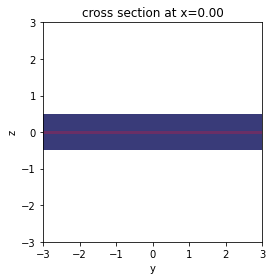

In [3]:
waveguide = td.Structure(
    geometry = td.Box(size=(wg_width, td.inf, wg_height)),
    medium = td.Medium(permittivity=wg_permittivity)
)
monitor = td.FieldMonitor(
    size=(td.inf, td.inf, 0),
    freqs=[freq_hz],
    name='field'
)

sim = td.Simulation(
    size=(Lx, Ly, Lz),
    grid_size=(dl, dl, dl),
    pml_layers=(None, None, None),
    structures=[waveguide],
    monitors=[monitor],
)

ax = sim.plot(x=0)

## Initialize Mode Solver

With our system defined, we can now create our mode solver.

We first need to specify on what plane we want to solve the modes using a `td.Box()` object.

In [4]:
plane = td.Box(
    center=(0,0,0),
    size=(Lx, 0, Lz)
)

Then we can initialize a `ModeSolver()` object to solve for the modes at frequency `freq` on plane `plane` in `sim`.

The mode solver will evaluate the complex-valued permittivity of `simulation` on `plane` at frequency `freq` and use this for the mode solver.

In [5]:
from tidy3d.plugins import ModeSolver

mode_solver = ModeSolver(
    simulation=sim,
    plane=plane,
    freq=freq_hz
)

## Define Mode

The goal of the mode solver is to determine a `td.Mode()` specification that can be used in your actual Tidy3d simulation.

We can define such a specification using

- `mode_index`: integer (return the `mode_index`-th result of the solver, generally this refers to the mode with the `mode_index`-th lowest effective index.

- `target_neff`: float, default=None, guess for the n_eff of the mode, if not specified, chooses the maximum real part of the refractive index in the cross section.

- `symmetry`: tuple of 2 integers, default=(0,0), with the first and second value being one of {0: no symmetry, 1: PMC (even), -1: PEC (odd)}.  These set the symmetry on the two axes of the plane.

- `num_pml`: tuple of 2 integers, default=(0,0) specifying how many pml layers to place on the two axes of the plane.

For example:

In [6]:
mode_spec = td.ModeSpec(
    num_modes=3,
    target_neff=2.0,
    symmetries=(0,0),
    num_pml=(0,0)
)

Once we have the mode specification, we can `solve` for the mode information using our `ModeSolver()` instance.

In [7]:
modes_info = mode_solver.solve(mode_spec)
first_mode = modes_info[0]

## Visualizing Mode Data

The `mode_info` object contains information about the effective index of the mode and the field profiles.

The effective index information can be accessed as follows.

In [8]:
n_eff = first_mode.n_eff
k_eff = first_mode.k_eff

print(f'found: n_eff = {n_eff:.2f}, k_eff = {k_eff:.2e}')

found: n_eff = 1.74, k_eff = -1.67e-17


The `mode_info.field_data` attribute is a `td.FieldData` instance that can be visualized and analyzed using the various methods provided by `FieldData` objects.

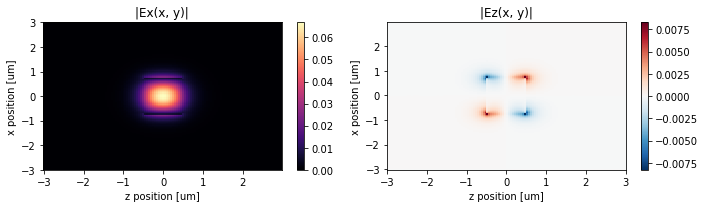

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
abs(first_mode.field_data.Ex).plot(ax=ax1, cmap='magma')
first_mode.field_data.Ez.real.plot(ax=ax2)

# mode_info.field_data.Ez.real.plot.real.plot.pcolormesh(x='y', y='z', ax=ax2)
ax1.set_title('|Ex(x, y)|')
ax2.set_title('|Ez(x, y)|')
plt.show()

## Refining the Mode information

In typical settings, one would want to tweak the parameters in the `Mode` specification nd run again.

For example, if we wanted to find the next higher order mode, we can adjust `Mode.mode_index` and solve again.

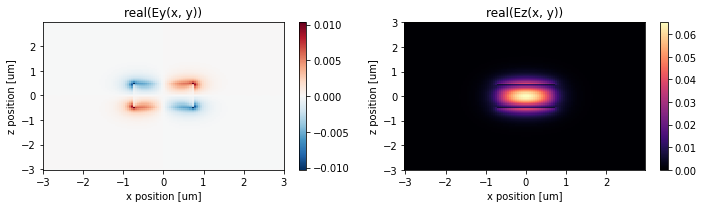

In [10]:
second_mode = modes_info[1]
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
second_mode.field_data.Ex.real.plot(x='x', y='z', ax=ax1)
abs(second_mode.field_data.Ez).plot(x='x', y='z', ax=ax2, cmap='magma',)
ax1.set_title('real(Ey(x, y))')
ax2.set_title('real(Ez(x, y))')
plt.show()

This looks like an Ez-dominant mode, if instead we wanted a higher order Ey-dominant mode, let's try again speciying that we want to solve 4 modes and select with `mode_index=3`.

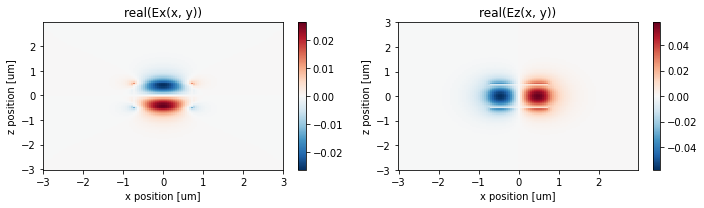

In [11]:
third_mode = modes_info[2]
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
third_mode.field_data.Ex.real.plot(x='x', y='z', ax=ax1)
third_mode.field_data.Ez.real.plot(x='x', y='z', ax=ax2)
ax1.set_title('real(Ex(x, y))')
ax2.set_title('real(Ez(x, y))')
plt.show()

## Exporting Results

This looks promising!

Now we may want to export this `Mode` specification to use in our main tidy3d script.

There are several ways to do this:

### As Source
The `Mode` object used in the `ModeSolver` can be used directly to define a `ModeSource` or `ModeMonitor`, for example:

In [12]:
fwidth = freq_hz/10
mode_source = mode_solver.to_source(mode_spec, mode_index=2, fwidth=fwidth, direction='-')

sim = td.Simulation(
    size=(Lx, Ly, Lz),
    grid_size=(dl, dl, dl),
    run_time=20/fwidth,
    pml_layers=(td.PML(), td.PML(), td.PML()),
    structures=[waveguide],
    sources=[mode_source],
    monitors=[monitor]
)

In [13]:
import tidy3d.web as web
job = web.Job(simulation=sim, task_name='mode_simulation')
sim_data = job.run(path='data/simulation_data.hdf5')

Using Tidy3D credentials from stored file


[11:42:35] INFO     Uploaded task 'mode_simulation' with task_id                ]8;id=609357;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=517778;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#108\108]8;;\
                    'c7a2ff2d-b1da-4f21-820e-fd06c1c0f979'.

Output()

[11:43:08] status = running                                                  ]8;id=642899;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=729765;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#142\142]8;;\

[11:43:23] status = postprocess                                              ]8;id=933982;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=575679;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#142\142]8;;\

[11:43:39] status = visualize                                                ]8;id=273320;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=7786;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#142\142]8;;\

[11:44:11] status = success                                                  ]8;id=660357;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=120100;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#142\142]8;;\

[11:44:12] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=766699;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=219996;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#479\479]8;;\
                    "data/simulation_data.hdf5"

Output()

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

[11:44:14] INFO     loading SimulationData from data/simulation_data.hdf5       ]8;id=70406;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=307809;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#300\300]8;;\

<matplotlib.collections.QuadMesh object at 0x7fbb4524c850>

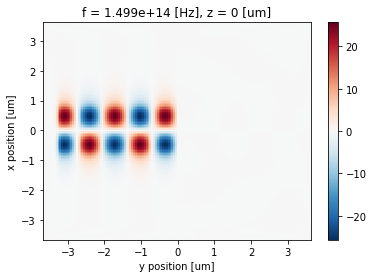

In [14]:
ax = sim_data['field'].Ez.interp(z=0).real.plot()

### Save and Load
Like most tidy3d components, the `mode` can be exported to .json and loaded in your main script, if runnning mode solver as a separate program.

In [15]:
# save to file
fname = 'data/mode_spec.json'
mode_spec.to_file(fname)

# in your main script, load file and use mode
mode_spec = td.ModeSpec.from_file(fname)

### Copy and Paste

One can also simply print the mode and copy and paste this information into the main script to hard-code the specifications

In [16]:
print(f'mode_spec = td.ModeSpec({mode_spec})')

mode_spec = td.ModeSpec(num_modes=3 target_neff=2.0 symmetries=(0, 0) num_pml=(0, 0) bend_radius=None bend_axis=None type='ModeSpec')


In [17]:
# copy and paste output in your file
print(mode_spec)

num_modes=3 target_neff=2.0 symmetries=(0, 0) num_pml=(0, 0) bend_radius=None bend_axis=None type='ModeSpec'


### ModeSolver methods
Finally, the `ModeSolver` provides some convenience methods for returning `ModeSource` and `ModeMonitor` objects.

In [18]:
# makes a modal source with geometry of `plane`, source_time given by `freq_hz` and `fwidth` and `mode` specified by `mode`
mode_src = mode_solver.to_source(mode_spec=mode_spec, mode_index=2, fwidth=freq_hz, direction='-')

# makes a mode monitor with geometry of `plane`, `td.FreqSampler` given by a list of frequencies and `mode` specified by `mode`
mode_mon = mode_solver.to_monitor(mode_spec=mode_spec, freqs=[0.9 * freq_hz, freq_hz, 1.1*freq_hz], name='mode')

## Advanced Use

Here are some more advanced functionalities of the mode solver for practical use:

### "Scanning" modes
One might want to view how a mode behaves over a range of frequencies, for now, just iterate:

freq = 600 THz
	- neff = 1.96
	- keff = 2.05e-12
freq = 400 THz
	- neff = 1.91
	- keff = 6.06e-18
freq = 300 THz
	- neff = 1.84
	- keff = 7.74e-12
freq = 240 THz
	- neff = 1.76
	- keff = -6.03e-10
freq = 200 THz
	- neff = 1.66
	- keff = 1.14e-17


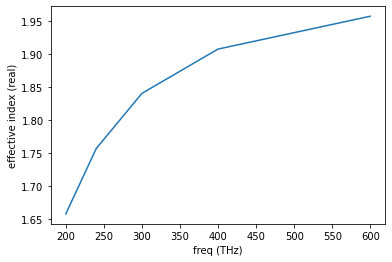

In [19]:
freqs = C_0 / np.linspace(0.5, 1.5, 5)
neffs = []
for freq in freqs:
    mode_solver = ModeSolver(
        simulation=sim,
        plane=plane,
        freq=freq)
    mode_info = mode_solver.solve(mode_spec)[2]
    print(f'freq = {(freq/1e12):.0f} THz\n\t- neff = {mode_info.n_eff:.2f}\n\t- keff = {mode_info.k_eff:.2e}')
    neffs.append(mode_info.n_eff)
    # or, get field data and plot

plt.plot(freqs / 1e12, neffs)
plt.xlabel('freq (THz)')
plt.ylabel('effective index (real)')
plt.show()

### Viewing multiple mode specifications
One might want to view multiple mode specifications side by side, for now, just iterate:

mode index = 0
	- neff = 1.84
	- keff = 1.74e-18
mode index = 1
	- neff = 1.81
	- keff = 8.72e-18
mode index = 2
	- neff = 1.66
	- keff = -1.36e-17
mode index = 3
	- neff = 1.64
	- keff = 3.96e-18
mode index = 4
	- neff = 1.53
	- keff = -2.88e-14


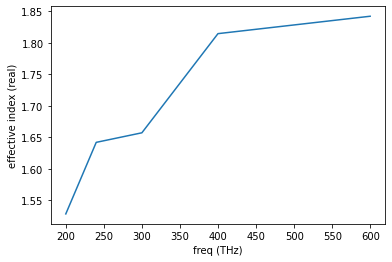

In [20]:
mode_indices = np.arange(0, 5)
mode_solver = ModeSolver(
    simulation=sim,
    plane=plane,
    freq=freq)
mode_spec = td.ModeSpec(num_modes=max(mode_indices)+1)


neffs = []
for mode_index in mode_indices:
    mode_info = mode_solver.solve(mode_spec)[mode_index]
    print(f'mode index = {mode_index}\n\t- neff = {mode_info.n_eff:.2f}\n\t- keff = {mode_info.k_eff:.2e}')
    neffs.append(mode_info.n_eff)
    # or, get field data and plot

plt.plot(freqs / 1e12, neffs)
plt.xlabel('freq (THz)')
plt.ylabel('effective index (real)')
plt.show()

## Notes / Considerations

- This mode solver runs locally, which means it does not require credits to run.
- It also means that the mode solver does not use subpixel-smoothening, even if this is specified in the simulation.  Therefore, the results might not perfectly match what we compute with `simulation.subpixel=True`.
- Symmetries are applied to the cross section of the permittivity parsed from the simulation.  It uses the upper quadrant data to fill the full `plane`.  